In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys
sys.path.append('/Users/abhishek/Projects/experimental-timeflow/')
import timeflow as tflow
import timesynth as ts
%matplotlib inline

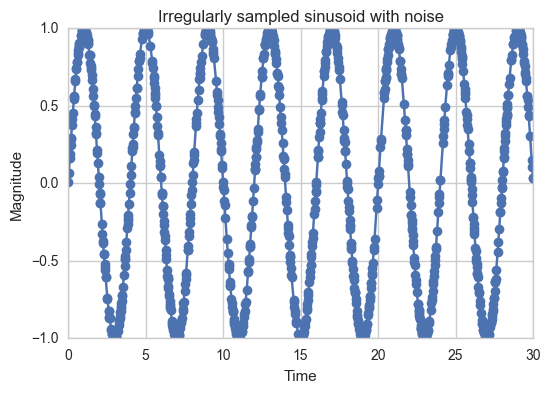

In [2]:
#Initializing TimeSampler
time_sampler = ts.TimeSampler(stop_time=30)
#Sampling regular time samples
irregular_time_samples = time_sampler.sample_irregular_time(num_points=2000, keep_percentage=50)
#Initializing Sinusoidal signal
sinusoid = ts.signals.Sinusoidal(frequency=0.25)
#Initializing Gaussian noise
white_noise = ts.noise.GaussianNoise(std=0.3)
#Initializing TimeSeries class with the signal and noise objects
timeseries = ts.TimeSeries(sinusoid, noise_generator=None)
#Sampling using the irregular time samples
samples, signals, errors = timeseries.sample(irregular_time_samples)
#Plotting the series
plt.plot(irregular_time_samples, samples, marker='o')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Irregularly sampled sinusoid with noise')

In [3]:
X, Y, time_vector = tflow.features.irregular_prediction(irregular_time_samples, samples)
num_training_points = 100
num_validation_points = 100
X_train = X[:num_training_points, :]
Y_train = Y[:num_training_points, :]
X_valid = X[num_training_points:num_training_points+num_validation_points, :]
Y_valid = Y[num_training_points:num_training_points+num_validation_points, :]
X_test = X[num_training_points+num_validation_points:, :]
Y_test = Y[num_training_points+num_validation_points:, :]

In [4]:
input_size = 4
hidden_size = 50
output_size = 1

In [5]:
with tf.variable_scope('Input'):
    inputs = tflow.placeholders.prediction.input_placeholder(input_size)
with tf.variable_scope('Input_LSTM_Layer'):
    input_lstm_layer = tflow.layers.InputLSTMLayer(inputs, input_size)
with tf.variable_scope('LSTM_Layer'):
    lstm_layer = tflow.layers.LSTMLayer(input_size, hidden_size, input_lstm_layer)
with tf.variable_scope('Regression_Layer'):
    reg_layer = tflow.layers.RegressionLayer(hidden_size, output_size, lstm_layer)

In [6]:
outputs = reg_layer.get_outputs()[:, 0, :]

In [7]:
y = tflow.placeholders.prediction.output_placeholder(output_size)

In [8]:
# Defining MSE as the loss function
with tf.variable_scope('RMSE'):
    loss_func = tflow.utils.metrics.RMSE(outputs, y)
# Defining R2 for additional logging
with tf.variable_scope('R2'):
    R2 = tflow.utils.metrics.R2(outputs, y)

In [9]:
# Training with Adadelta Optimizer
train_step = tf.train.RMSPropOptimizer(learning_rate=0.05).minimize(loss_func)

In [10]:
# Starting tensorflow session
sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [11]:
num_iterations = 10

In [12]:
# Training the model
for i in range(num_iterations):
    sess.run(train_step, feed_dict={inputs: X_train,
                                    y: Y_train})
    # Calculating the score for the validation set
    score = sess.run(loss_func, feed_dict={inputs: X_valid,
                                           y: Y_valid})
    
    
    # Calculating the autocorrelation after every training iteration
    predicted_series_train = sess.run(outputs,feed_dict={inputs:X_train})
    delta_t_vec = np.reshape(X_train[:, 1], (len(X_train[:, 1]), 1))[1:]
    # Computing the residuals
    res = Y_train - predicted_series_train
    # Shifting and building the inputs
    res_vector = np.concatenate((res[1:], res[:-1]), axis=1)
    delta_time_input = tf.placeholder(tf.float32, shape=[None, 1], name='delta_t')
    signal_input = tf.placeholder(tf.float32, shape=[None, 2], name='signal')
    auto_corr_obj = tflow.utils.AutoCorrEstimator(delta_time_input, signal_input)
    phi_est, sigma_est = auto_corr_obj.minimize_log_loss(delta_t_vec, res_vector)
    
    print "Validation score after iteration %d : %f"%(i+1, score)
    print "Best estimate of phi is %f and sigma is %f"%(phi_est, sigma_est)

Validation score after iteration 1 : 0.430446
Best estimate of phi is nan and sigma is nan
Validation score after iteration 2 : 0.424165
Best estimate of phi is 0.743738 and sigma is 1.178864
Validation score after iteration 3 : 0.419341
Best estimate of phi is 0.774066 and sigma is 1.265189
Validation score after iteration 4 : 0.415749
Best estimate of phi is 0.901494 and sigma is 1.975369
Validation score after iteration 5 : 0.413182
Best estimate of phi is nan and sigma is nan
Validation score after iteration 6 : 0.411455
Best estimate of phi is 0.928606 and sigma is 2.334020
Validation score after iteration 7 : 0.410405
Best estimate of phi is nan and sigma is nan
Validation score after iteration 8 : 0.409884
Best estimate of phi is 0.057612 and sigma is 3.906291
Validation score after iteration 9 : 0.409762
Best estimate of phi is nan and sigma is nan
Validation score after iteration 10 : 0.409931
Best estimate of phi is nan and sigma is nan


In [ ]:
predicted_series = sess.run(outputs,feed_dict={inputs:X})

In [ ]:
tflow.utils.plotting.plot_residuals(predicted_series, Y, time_vector,
                                    num_training_points, num_validation_points)

In [ ]:
delta_t_vec = np.reshape(X[:, 1], (len(X[:, 1]), 1))[1:]

In [ ]:
## Computing the residuals
res = Y - predicted_series
## Shifting and building the inputs
res_vector = np.concatenate((res[1:], res[:-1]), axis=1)

In [ ]:
#### Computing the autocorrelation of the residuals
# Initializing the input placeholders
delta_time_input = tf.placeholder(tf.float32, shape=[None, 1], name='delta_t')
signal_input = tf.placeholder(tf.float32, shape=[None, 2], name='signal')
auto_corr_obj = tflow.utils.AutoCorrEstimator(delta_time_input, signal_input)

#### Attempting continuous prediction

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys
sys.path.append('/Users/abhishek/Projects/experimental-timeflow/')
import timeflow as tflow
import timesynth as ts
%matplotlib inline
from tqdm import tqdm

In [ ]:
#Initializing TimeSampler
time_sampler = ts.TimeSampler(stop_time=30)
#Sampling regular time samples
irregular_time_samples = time_sampler.sample_irregular_time(num_points=600, keep_percentage=50)
#Initializing Sinusoidal signal
sinusoid = ts.signals.Sinusoidal(frequency=0.25)
#Initializing Gaussian noise
white_noise = ts.noise.GaussianNoise(std=0.3)
#Initializing TimeSeries class with the signal and noise objects
timeseries = ts.TimeSeries(sinusoid, noise_generator=None)
#Sampling using the irregular time samples
samples, signals, errors = timeseries.sample(irregular_time_samples)
#Plotting the series
plt.plot(irregular_time_samples, samples, marker='o')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Irregularly sampled sinusoid with noise')

In [ ]:
samples = np.reshape(samples, (len(samples), 1))
irregular_time_samples_ = irregular_time_samples
irregular_time_samples = np.reshape(irregular_time_samples, (len(irregular_time_samples), 1))
diff_time_samples = np.reshape(np.diff(irregular_time_samples_), (len(irregular_time_samples_)-1, 1))

In [ ]:
# Dataset feature engineering for basic testing
X = np.concatenate((samples[:-1], diff_time_samples), axis=1)
# X = diff_time_samples
Y = samples[1:]
# Splitting into training, validation and testing sets
num_training_points = 100
num_validation_points = 100
X_train = X[:num_training_points, :]
Y_train = Y[:num_training_points, :]
X_valid = X[num_training_points:num_training_points+num_validation_points, :]
Y_valid = Y[num_training_points:num_training_points+num_validation_points, :]
X_test = X[num_training_points+num_validation_points:, :]
Y_test = Y[num_training_points+num_validation_points:, :]

In [ ]:
input_size = 3
hidden_size = 50
output_size = 1

In [ ]:
#Single LSTM layer without any batch inputs
class LSTMLayer():
    """
    This layer implements the LSTM cell.
    """
    """
    This layer implements the LSTM cell.
    """
    def __init__(self, input_dim, hidden_layer_size, output_size, input_layer):
        """Initialize LSTMLayer class

        Parameters
        ----------
        input_dim : integer
            Input dimensions
        hidden_layer_size : integer
            Size of the memory in LSTM cell
        output_dim : integer
            Output dimensions
        input_layer : layers object
            Preceding layers object

        """
        self.input_dim = input_dim
        self.hidden_layer_size = hidden_layer_size
        self.inputs = input_layer.get_outputs()
        self.output_dim = output_size

        # Initializing the weights and biases
        self.Wi = tf.Variable(tf.zeros([self.input_dim, self.hidden_layer_size]))
        self.Ui = tf.Variable(tf.zeros([self.hidden_layer_size, self.hidden_layer_size]))
        self.bi = tf.Variable(tf.zeros([self.hidden_layer_size]))

        self.Wf = tf.Variable(tf.zeros([self.input_dim, self.hidden_layer_size]))
        self.Uf = tf.Variable(tf.zeros([self.hidden_layer_size, self.hidden_layer_size]))
        self.bf = tf.Variable(tf.zeros([self.hidden_layer_size]))

        self.Wog = tf.Variable(tf.zeros([self.input_dim, self.hidden_layer_size]))
        self.Uog = tf.Variable(tf.zeros([self.hidden_layer_size, self.hidden_layer_size]))
        self.bog = tf.Variable(tf.zeros([self.hidden_layer_size]))

        self.Wc = tf.Variable(tf.zeros([self.input_dim, self.hidden_layer_size]))
        self.Uc = tf.Variable(tf.zeros([self.hidden_layer_size, self.hidden_layer_size]))
        self.bc = tf.Variable(tf.zeros([self.hidden_layer_size]))

        self.Wo = tf.Variable(tf.truncated_normal(
            [self.hidden_layer_size, self.output_dim],mean=0,stddev=.01))
        self.bo = tf.Variable(tf.truncated_normal([self.output_dim],mean=0,stddev=.01))

        
        self.initial_hidden = tf.zeros([1, self.hidden_layer_size])
        self.initial_output = tf.zeros([1, self.output_dim])
        #Packing the hidden output and the initial output
        self.initial_hidden= tf.pack([self.initial_hidden, self.initial_hidden])
        self.starter_values = (self.initial_hidden, self.initial_output)
        
    def forward_step(self, previous_memory_, _input_):
        """
        Generates the next forward LSTM operation

        Parameters
        ----------
        previous_memory : list
            List of the previous memory and hidden output tensors
        input_ : tf.tensor
            Input tensor

        Returns
        ----------
        list
            New updated memory and hidden output tensors

        """
        previous_memory, input_prev = previous_memory_
        previous_hidden_state, c_prev = tf.unpack(previous_memory)
        input_ = tf.concat(1, (input_prev, _input_))
        # Input gate
        i= tf.sigmoid(
            tf.matmul(input_,self.Wi)+tf.matmul(previous_hidden_state,self.Ui) + self.bi
        )
        # Forget Gate
        f= tf.sigmoid(
            tf.matmul(input_,self.Wf)+tf.matmul(previous_hidden_state,self.Uf) + self.bf
        )
        # Output Gate
        o= tf.sigmoid(
            tf.matmul(input_,self.Wog)+tf.matmul(previous_hidden_state,self.Uog) + self.bog
        )
        # New Memory Cell
        c_= tf.nn.tanh(
            tf.matmul(input_,self.Wc)+tf.matmul(previous_hidden_state,self.Uc) + self.bc
        )
        # Final Memory cell
        c= f*c_prev + i*c_

        # Current Hidden state
        current_hidden_state = o*tf.nn.tanh(c)
        
        # Calculating the outputs from current hidden state
        output = tf.matmul(current_hidden_state, self.Wo) + self.bo
        
        return (tf.pack([current_hidden_state,c]), output)

    # Function for getting all hidden state.
    def get_outputs(self):
        """
        Iterates through time/ sequence to get all hidden state

        Returns
        ----------
        tf.Tensor
            Output tensor

        """
        # Getting all hidden state throuh time
        self.inputs = tf.expand_dims(self.inputs[0, :, :], 1)
        all_hidden_states_out = tf.scan(self.forward_step,
                                        self.inputs,
                                        initializer=self.starter_values,
                                        name='states')
        all_hidden_states, outputs = all_hidden_states_out
        all_hidden_states = all_hidden_states[:, 0, :, :]
        return outputs[:, 0, :]

In [ ]:
input_size_ = input_size-1

In [ ]:
with tf.variable_scope('Input'):
    inputs = tflow.placeholders.prediction.input_placeholder(input_size_)
with tf.variable_scope('Input_LSTM_Layer'):
    input_lstm_layer = tflow.layers.InputLSTMLayer(inputs, input_size_)
with tf.variable_scope('LSTM_Layer'):
    lstm_layer = LSTMLayer(input_size, hidden_size, output_size, input_lstm_layer)

In [ ]:
outputs = lstm_layer.get_outputs()

In [ ]:
y = tflow.placeholders.prediction.output_placeholder(output_size)

In [ ]:
# Defining MSE as the loss function
with tf.variable_scope('RMSE'):
    loss_func = tflow.utils.metrics.RMSE(outputs, y)
# Defining R2 for additional logging
with tf.variable_scope('R2'):
    R2 = tflow.utils.metrics.R2(outputs, y)

In [ ]:
tf.summary.scalar("RMSE", loss_func)
summary_op = tf.summary.merge_all()

In [ ]:
# Training with Adadelta Optimizer
train_step = tf.train.RMSPropOptimizer(learning_rate=0.05).minimize(loss_func)

In [ ]:
# Starting tensorflow session
sess=tf.InteractiveSession()
tf.global_variables_initializer().run()

In [ ]:
#Setting up log directory for tensorboard
logs_path = '../tmp/pred/1'
writer = tf.train.SummaryWriter(logs_path, graph=tf.get_default_graph())

In [ ]:
monitor = tflow.trainer.AutomatedTrainingMonitor(inputs, y, X_train, Y_train,
                                                 train_step, loss_func, sess, training_steps=1000,
                                                 validation_input=X_valid, validation_output=Y_valid,
                                                 early_stopping_rounds=50)

In [ ]:
monitor.train()

In [ ]:
predicted_series = sess.run(outputs,feed_dict={inputs:X})

In [ ]:
tflow.utils.plotting.plot_residuals(predicted_series, Y, irregular_time_samples[1:],
                                    num_training_points, num_validation_points)

In [ ]:
plt.plot(irregular_time_samples[1:], predicted_series)
plt.plot(irregular_time_samples)

In [ ]:
# Training the model
for i in tqdm(range(num_training_iterations)):
    _, summary = sess.run([train_step, summary_op],
                         feed_dict={inputs:X_train,
                                    y:Y_train})
    writer.add_summary(summary, i)
    
    #Calculating the validation error
    val_error = sess.run(loss_func,
                         feed_dict={inputs:X_valid,
                                    y:Y_valid})

    validation_errors.append(val_error)